In [26]:
import utils

In [27]:
import json
import os

MAP = "outdoor"

dwa = utils.load_data(os.path.abspath("dumped_data"), MAP, "dwa")
tr = utils.load_data(os.path.abspath("dumped_data"), MAP, "tr")
teb = utils.load_data(os.path.abspath("dumped_data"), MAP, "teb")
mpc = utils.load_data(os.path.abspath("dumped_data"), MAP, "mpc")

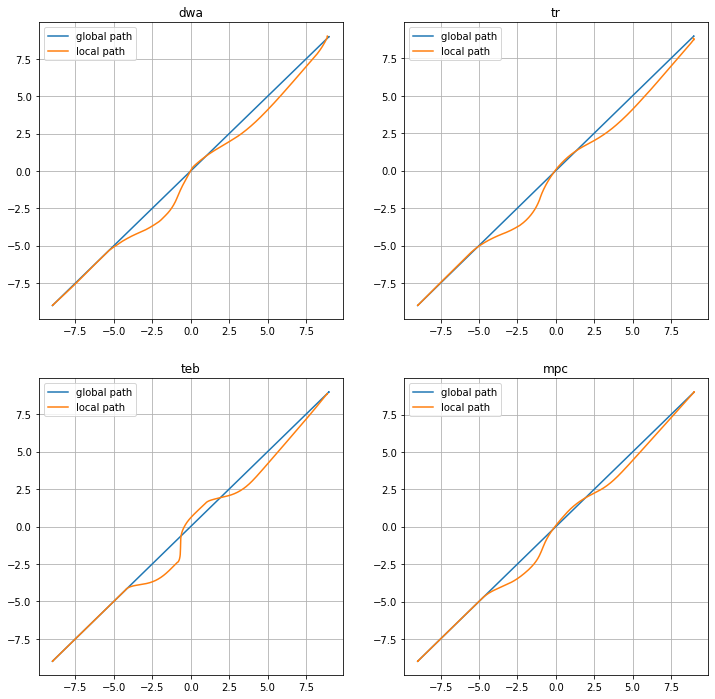

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, approach in enumerate([dwa, tr, teb, mpc]):
    ax = axs[i//2][i%2]
    ax.grid(True, "both")
    ax.plot(approach.global_path.x, approach.global_path.y, label="global path")
    ax.plot(approach.local_path.x, approach.local_path.y, label="local path")
    ax.title.set_text(approach.approach_name)
    ax.legend()

plt.show()


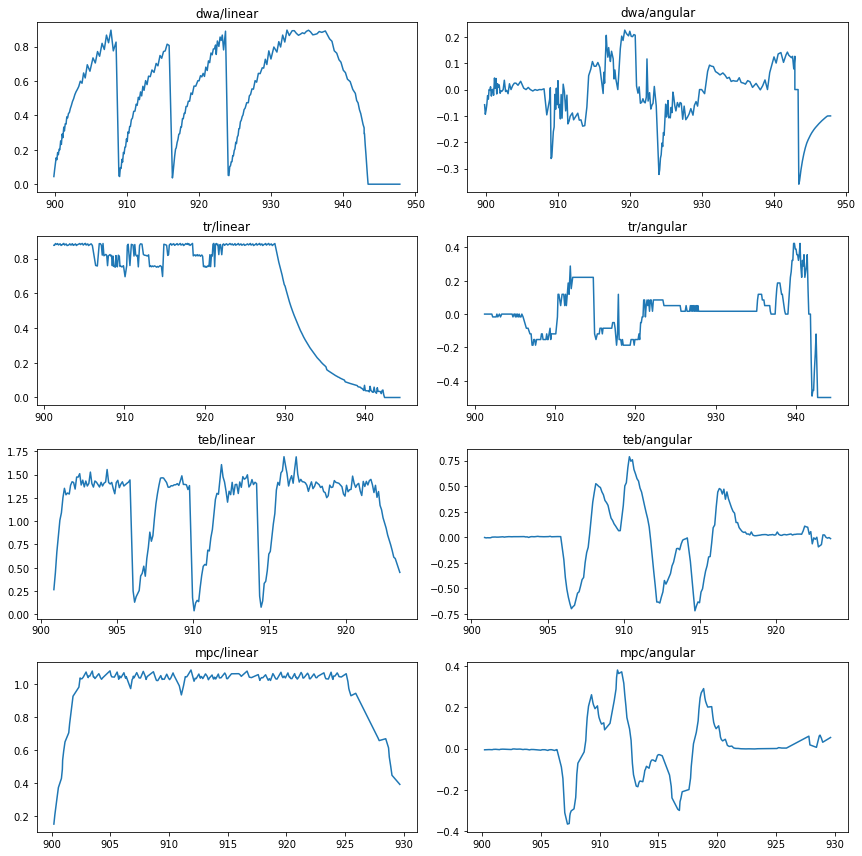

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

map(lambda ax: ax.grid(True, "both"), [ax for sublist in axs for ax in sublist])

for i, approach in enumerate([dwa, tr, teb, mpc]):
    axs[i][0].plot(approach.velocity.t, approach.velocity.linear)
    axs[i][1].plot(approach.velocity.t, approach.velocity.angular)
    axs[i][0].title.set_text(f"{approach.approach_name}/linear")
    axs[i][1].title.set_text(f"{approach.approach_name}/angular")

fig.tight_layout()
plt.show()

#### Гладкость скоростей

In [30]:
import pandas as pd

smoothness = {a.approach_name: {"linear": 0, "angular": 0} for a in [dwa, tr, teb, mpc]}
for a, t in [(a, t) for a in [dwa, tr, teb, mpc] for t in ["linear", "angular"]]:
    smoothness[a.approach_name][t] = utils.evaluate_smoothness(a.velocity, "t", t, angle_fix=t=="angular")

smoothness = pd.DataFrame(smoothness).T
smoothness["common"] = smoothness.linear + smoothness.angular
smoothness.round(3)

,linear,angular,common
dwa,15.770,33.423,49.192
tr,11.532,20.797,32.329
teb,15.201,9.145,24.346
mpc,9.051,13.544,22.595


#### Гладкость пути

In [31]:

{a.approach_name: utils.evaluate_smoothness(a.local_path, "t", "x", "y") for a in [dwa, tr, teb, mpc]}

{'dwa': 0.8288983926327047,
 'tr': 0.9114055093822905,
 'teb': 0.745948284483799,
 'mpc': 0.6978715042893753}

#### Отклонение от маршрута

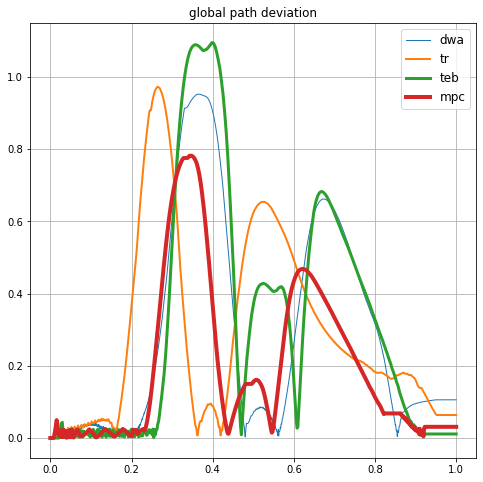

In [32]:
normalize = lambda data: (data - data.min())/(data.max() - data.min())

plt.figure(figsize=(8, 8))
plt.grid(True, "both")
plt.title("global path deviation")
for w, a in enumerate([dwa, tr, teb, mpc], start=1):
    plt.plot(
        normalize(a.global_path_deviation.t),
        a.global_path_deviation.dist,
        linewidth=w, label=f"{a.approach_name}"
    )
plt.legend(fontsize="large")
plt.show()


In [33]:
pd.DataFrame(
    {a.approach_name: a.measured_deviation.__dict__ for a in [dwa, tr, teb,mpc]}
)

,dwa,tr,teb,mpc
absolute,14.518222,13.320139,8.185896,6.440569
relative,0.561464,0.515142,0.310778,0.249467


In [34]:
{a.approach_name: a.travel_time for a in [dwa, tr, teb, mpc]}

{'dwa': 47.98000000000002,
 'tr': 43.101999999999975,
 'teb': 22.69100000000003,
 'mpc': 29.456999999999994}

In [35]:
{a.approach_name: a.freq for a in [dwa, tr, teb, mpc]}


{'dwa': 6.622516556293425,
 'tr': 9.90099009900999,
 'teb': 9.999999999997726,
 'mpc': 9.90099009900999}

In [36]:
summary = pd.DataFrame({a.approach_name: {
    "route_smoothness": utils.evaluate_smoothness(a.local_path, "t", "x", "y"),
    "velocity_smoothness": utils.evaluate_smoothness(a.velocity, "t", "linear") + utils.evaluate_smoothness(a.odom_velocity, "t", "angular"),
    "avg_velocity": a.velocity.linear.mean(),
    "max_velocity": a.velocity.linear.max(),
    "route_deviation": a.measured_deviation.relative,
    "travel_time": a.travel_time,
    "freq_time": a.freq,
} for a in [dwa, tr, teb, mpc]}).T

summary.round(4)

,route_smoothness,velocity_smoothness,avg_velocity,max_velocity,route_deviation,travel_time,freq_time
dwa,0.8289,62.8137,0.4267,0.8957,0.5615,47.980,6.6225
tr,0.9114,44.9675,0.5987,0.8873,0.5151,43.102,9.9010
teb,0.7459,34.4234,1.1770,1.6921,0.3108,22.691,10.0000
mpc,0.6979,33.4482,0.9859,1.0873,0.2495,29.457,9.9010


In [37]:
norm_summary = summary.copy()
norm_summary.route_smoothness = 1 / (summary.route_smoothness / summary.route_smoothness.min())
norm_summary.velocity_smoothness = 1 / (summary.velocity_smoothness / summary.velocity_smoothness.min())
norm_summary.route_deviation = 1 / (summary.route_deviation / summary.route_deviation.min())
norm_summary.travel_time = 1 / (summary.travel_time / summary.travel_time.min())
norm_summary.avg_velocity = summary.avg_velocity / summary.avg_velocity.max()
norm_summary.max_velocity = summary.max_velocity / summary.max_velocity.max()
norm_summary.freq_time = summary.freq_time / summary.freq_time.max()
norm_summary["grade"] = norm_summary.apply(sum, axis=1)
norm_summary.round(4)

,route_smoothness,velocity_smoothness,avg_velocity,max_velocity,route_deviation,travel_time,freq_time,grade
dwa,0.8419,0.5325,0.3625,0.5294,0.4443,0.4729,0.6623,3.8458
tr,0.7657,0.7438,0.5087,0.5244,0.4843,0.5264,0.9901,4.5434
teb,0.9355,0.9717,1.0000,1.0000,0.8027,1.0000,1.0000,6.7099
mpc,1.0000,1.0000,0.8376,0.6426,1.0000,0.7703,0.9901,6.2406
